In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:  
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    #print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

In [6]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [7]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [8]:
#embedding lookup table
C = torch.randn((27, 2))
C[0]

tensor([0.6024, 0.1613])

In [9]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [10]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [11]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [12]:
h

tensor([[ 0.6194, -0.9935, -0.3801,  ...,  0.9623,  0.9577, -0.6969],
        [ 0.2976, -0.9985,  0.1248,  ...,  0.6229,  0.9529, -0.8862],
        [ 0.4467, -0.9942, -0.4144,  ..., -0.5249,  0.8659, -0.7305],
        ...,
        [ 0.9078,  0.1513, -0.9998,  ...,  0.9903,  0.9531,  0.9709],
        [ 0.4081, -0.9979,  0.7706,  ...,  0.9159,  0.9965, -0.7136],
        [ 0.7665, -0.9992, -0.9991,  ..., -0.1701,  0.9751,  0.7187]])

In [13]:
h.shape

torch.Size([228146, 100])

In [14]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [15]:
logits = h @ W2 + b2

In [16]:
logits.shape

torch.Size([228146, 27])

In [17]:
counts = logits.exp()

In [18]:
prob = counts / counts.sum(1, keepdims=True)

In [19]:
#indexing throught the probabilities with labels 
Y.shape

torch.Size([228146])

In [20]:
#negative log likelihood loss 
#loss = -prob[torch.arange(32), Y].log().mean()
#loss

In [21]:
# ------------ now made respectable :) ---------------
Xtr.shape, Ytr.shape # dataset

(torch.Size([182625, 3]), torch.Size([182625]))

- E01: Tune the hyperparameters of the training to beat my best validation loss of 2.2
best results after training on 20k epochs.
	-batch size : 64
	
	-content length:12
	
	-neuron size:200
	
	-learning rate:0.2
	
	-learning rate decay=0.0001
	
	-train loss: batch-training(2.1117842197418213) full-dataset(2.2994)
	
	-dev loss:2.3170


	only manage to beat the loss when after initialization  multiplied the parameters with w_mul=0.1

	-train loss(1.988325595855713,2.1294)
	
	-dev loss(2.1630)
	

In [312]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
context_length=10
neurons=200
C = torch.randn((27, context_length), generator=g)
W1 = torch.randn((context_length*3, neurons), generator=g)
b1 = torch.randn(neurons, generator=g)
W2 = torch.randn((neurons, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

learning_rate=0.1
learning_rate_decay=0.001


In [313]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [496]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
context_length=12
neurons=200
w_mul=0.1
C = torch.randn((27, context_length), generator=g)
W1 = torch.randn((context_length*3, neurons), generator=g) * w_mul 
b1 = torch.randn(neurons, generator=g)* w_mul
W2 = torch.randn((neurons, 27), generator=g) * w_mul
b2 = torch.randn(27, generator=g) * w_mul
parameters = [C, W1, b1, W2, b2]

learning_rate=0.2
learning_rate_decay=0.0001 


In [497]:
for p in parameters:
  p.requires_grad = True

In [498]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

lri = []
lossi = []
stepi = []

BATCH_SIZE=64

In [499]:
for i in range(20000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (BATCH_SIZE,))
  

  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, context_length*3) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  current_learning_rate=learning_rate*(1/(1+learning_rate_decay*i))
  for p in parameters:
    p.data += -current_learning_rate * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

3.5292835235595703
3.3845267295837402
3.0887086391448975
3.0572783946990967
3.0909276008605957
3.0518274307250977
2.973729372024536
3.070028781890869
2.9565510749816895
2.979124069213867
2.7315807342529297
2.8126728534698486
2.821843147277832
3.004305124282837
2.7873761653900146
2.6950671672821045
2.7093608379364014
2.8721120357513428
2.7476043701171875
2.7011728286743164
2.965446710586548
2.6569719314575195
2.983661413192749
2.9250524044036865
2.74569034576416
2.7184464931488037
2.759538412094116
2.7798502445220947
2.7393290996551514
2.9244003295898438
2.5503010749816895
2.7597644329071045
2.6137337684631348
2.70963716506958
2.60638165473938
2.6582603454589844
2.562321186065674
2.62288236618042
2.831730842590332
2.664806365966797
2.707937479019165
2.832188844680786
3.0039119720458984
2.761582136154175
2.573235511779785
2.6779534816741943
2.672074794769287
2.7488245964050293
2.795725107192993
2.6194510459899902
2.759410858154297
2.594541072845459
2.9210867881774902
2.561138868331909
2.

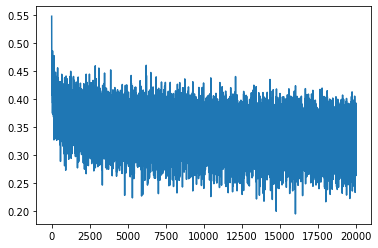

In [500]:
plt.plot(stepi, lossi)

In [501]:
#evaluate the train 
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, context_length*3) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1294, grad_fn=<NllLossBackward0>)

In [502]:
#evaluate the validation set  
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, context_length*3) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1630, grad_fn=<NllLossBackward0>)

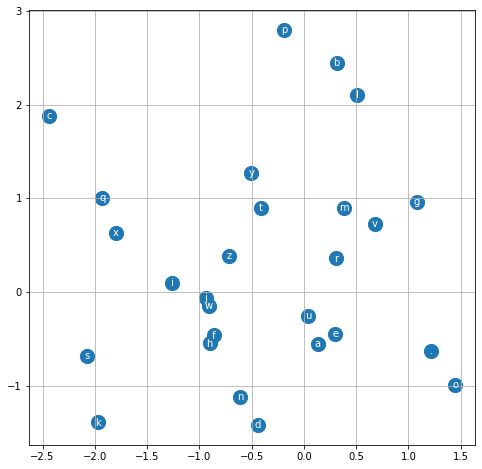

In [503]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [ ]:
# training split, dev/validation split, test split
# 80%, 10%, 10%

In [33]:
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

In [34]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carmah.
amille.
khlin.
shithty.
salaysa.
jazonte.
ameryst.
kaeli.
nelenia.
chaiivin.
lege.
dham.
elin.
quijons.
lilea.
jadii.
wavero.
dearixi.
faysenilsan.
emaedo.



- E02: I was not careful with the intialization of the network in this video. (1) What is the loss you'd get if the predicted probabilities at initialization were perfectly uniform? What loss do we achieve? (2) Can you tune the initialization to get a starting loss that is much more similar to (1)?
	
probably the purpose of the perfect uniform distribution at initialization is to avoid a hookey shape loss curve since at init the probabilities should be uniform since the network didn't have time to learn.
So we can try to initialize the weights random at multiply with 0.01 at the beggining.

when multiplying the parameters with 0.1 the init loss is less than it was before since its now 3.5292835235595703 at first epoch


- E03: Read the Bengio et al 2003 paper (link above), implement and try any idea from the paper. Did it work?

	i think trying to implement different size  for embeddeding table (10,30,60).


